In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
color = sns.color_palette()
%matplotlib inline
matplotlib.style.use('ggplot')

# remove warnings
import warnings
warnings.filterwarnings('ignore')

# my own module
from conf.configure import Configure

In [2]:
train = pd.read_csv(Configure.train_csv)
test = pd.read_csv(Configure.test_csv)

In [3]:
train.shape, test.shape

((30471, 292), (7662, 291))

In [4]:
train.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


** price_doc **

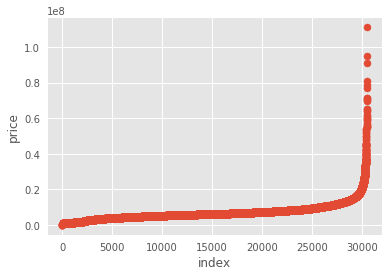

In [5]:
plt.figure(figsize=(6,4))
plt.scatter(range(train.shape[0]), np.sort(train.price_doc.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

In [6]:
train['yearmonth'] = train['timestamp'].apply(lambda x: x[:4]+x[5:7])
test['yearmonth'] = test['timestamp'].apply(lambda x: x[:4]+x[5:7])

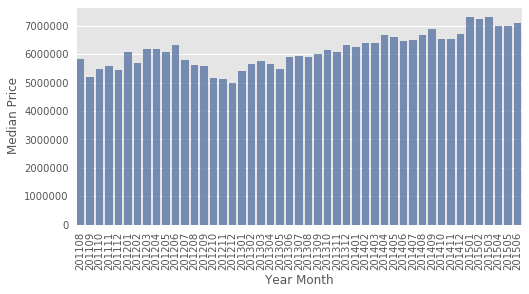

In [7]:
grouped_df = train.groupby(['yearmonth'])['price_doc'].aggregate('median').reset_index()

plt.figure(figsize=(8,4))
sns.barplot(grouped_df.yearmonth.values, grouped_df.price_doc.values, alpha=0.8, color=color[0])
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Year Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

可以看出 201108 到 201211 房价波动，之后呈现基本的线形增长的趋势，可以结合宏观经济进行分析

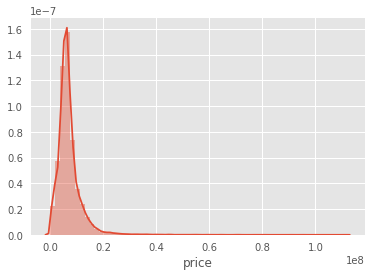

In [8]:
# price_doc 的价格分布
plt.figure(figsize=(6,4))
sns.distplot(train.price_doc.values, bins=60, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

可以看出价格呈现长尾分布，需要进行 `log(p+1)` 转换

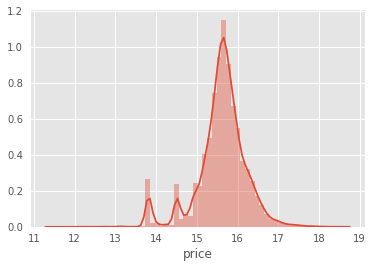

In [9]:
train['price_doc'] = np.log1p(train['price_doc'])
plt.figure(figsize=(6,4))
sns.distplot(train.price_doc.values, bins=60, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

** missing values in each column **

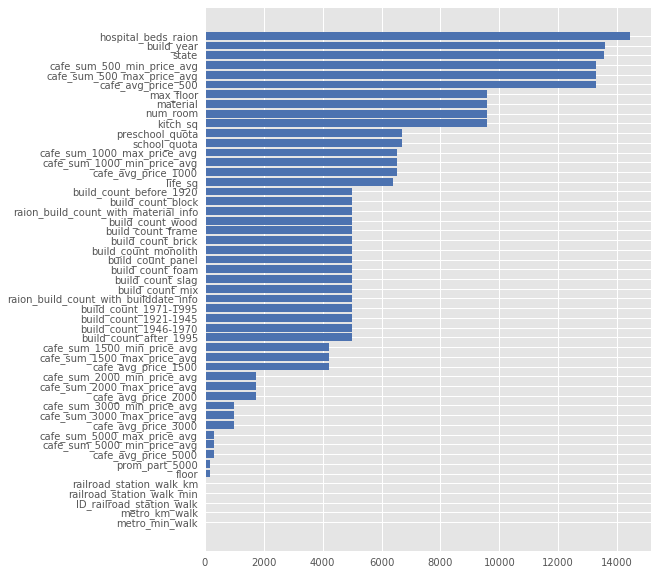

In [10]:
missing_df = train.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df[missing_df.missing_count > 0]
missing_df = missing_df.sort_values(by='missing_count')
ind = np.arange(missing_df.shape[0])
fig, ax = plt.subplots(figsize=(8,10))
ax.barh(ind, missing_df.missing_count.values, color=color[0])
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal');

缺失数据存在分组的现象，填充缺失数据时可以进行分组分析

In [11]:
def perform_missing_data(dataframe, columns, value):
    """ 填充缺失数据 """
    for column in columns:
        dataframe.loc[dataframe[column].isnull(), column] = value

** full_sq、 life_sq 和 kitch_sq 字段 **

In [12]:
train['full_sq'].isnull().sum(), train['life_sq'].isnull().sum(), train['kitch_sq'].isnull().sum()

(0, 6383, 9572)

In [13]:
perform_missing_data(train, ['life_sq', 'full_sq', 'kitch_sq'], 0)
perform_missing_data(test, ['life_sq', 'full_sq', 'kitch_sq'], 0)

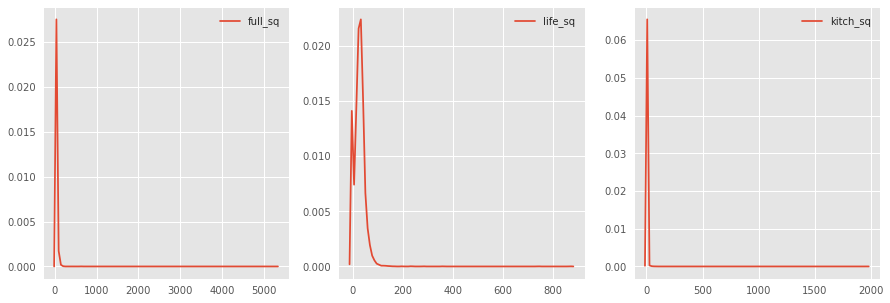

In [14]:
plt.figure(figsize=(15,5))
ax = plt.subplot(131)
sns.kdeplot(train['full_sq'])
ax = plt.subplot(132)
sns.kdeplot(test['life_sq'],ax=ax)
ax = plt.subplot(133)
sns.kdeplot(test['kitch_sq'],ax=ax)
plt.show()

In [15]:
sum(train['kitch_sq'] > train['full_sq']), sum(train['life_sq'] > train['full_sq'])

(12, 37)

In [16]:
# 去除 life_sq > full_sq 和 kitch_sq > full_sq 的异常数据
print train.shape
train = train[train['kitch_sq'] <= train['full_sq']]
train = train[train['life_sq'] <= train['full_sq']]
print train.shape

(30471, 293)
(30422, 293)


In [17]:
print '最大值：', test['full_sq'].max(), train['full_sq'].max()
print '训练集中 full_sq 大于测试集的最大值的数据个数：', train[train['full_sq'] > test['full_sq'].max()].shape[0]

最大值： 403.0 5326
训练集中 full_sq 大于测试集的最大值的数据个数： 9


In [18]:
gap = 50
# 去除训练集中出现的数据而测试集中没有出现的数据避免过拟合
print train.shape
train = train[train['full_sq'] <= test['full_sq'].max() + gap]
print train.shape
train = train[train['life_sq'] <= test['life_sq'].max() + gap]
print train.shape

(30422, 293)
(30415, 293)
(30415, 293)


In [19]:
# 添加面积比例
train['life_sq_ratio'] = train['life_sq'] / (train['full_sq'] + 1)
train['kitch_sq_ratio'] = train['kitch_sq'] / (train['full_sq'] + 1)
train['kitch_sq_vs_life_ratio'] = train['kitch_sq'] / (train['life_sq'] + 1)

test['life_sq_ratio'] = test['life_sq'] / (test['full_sq'] + 1)
test['kitch_sq_ratio'] = test['kitch_sq'] / (test['full_sq'] + 1)
test['kitch_sq_vs_life_ratio'] = test['kitch_sq'] / (test['life_sq'] + 1)

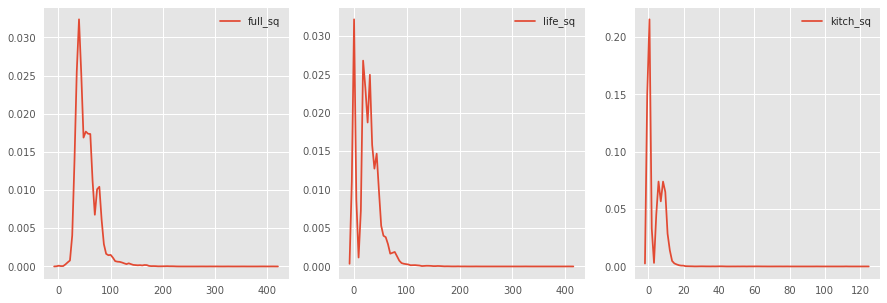

In [20]:
plt.figure(figsize=(15,5))
ax = plt.subplot(131)
sns.kdeplot(train['full_sq'])
ax = plt.subplot(132)
sns.kdeplot(train['life_sq'],ax=ax)
ax = plt.subplot(133)
sns.kdeplot(train['kitch_sq'],ax=ax)
plt.show()

In [21]:
# log1p 处理
train['full_sq'] = np.log1p(train['full_sq'])
test['full_sq'] = np.log1p(test['full_sq'])

train['life_sq'] = np.log1p(train['life_sq'])
test['life_sq'] = np.log1p(test['life_sq'])

train['kitch_sq'] = np.log1p(train['kitch_sq'])
test['kitch_sq'] = np.log1p(test['kitch_sq'])

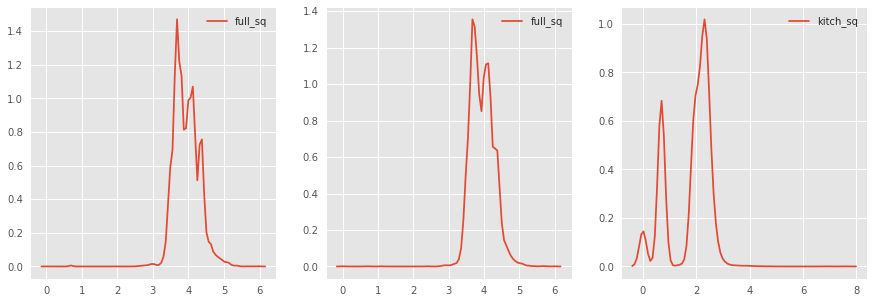

In [22]:
plt.figure(figsize=(15,5))
ax = plt.subplot(131)
sns.kdeplot(train['full_sq'])
ax = plt.subplot(132)
sns.kdeplot(test['full_sq'],ax=ax)
ax = plt.subplot(133)
sns.kdeplot(test['kitch_sq'],ax=ax)
plt.show()

In [23]:
print train.shape, test.shape

(30415, 296) (7662, 295)


** floor 和 max_floor 字段 **

In [24]:
print train['floor'].isnull().sum(), test['floor'].isnull().sum()
print train['max_floor'].isnull().sum(), test['max_floor'].isnull().sum()

166 0
9556 0


In [25]:
perform_missing_data(train, ['floor', 'max_floor'], 0)
perform_missing_data(test, ['floor', 'max_floor'], 0)

In [26]:
train['floor'] = train['floor'].map(lambda f: int(f))
train['max_floor'] = train['max_floor'].map(lambda f: int(f))

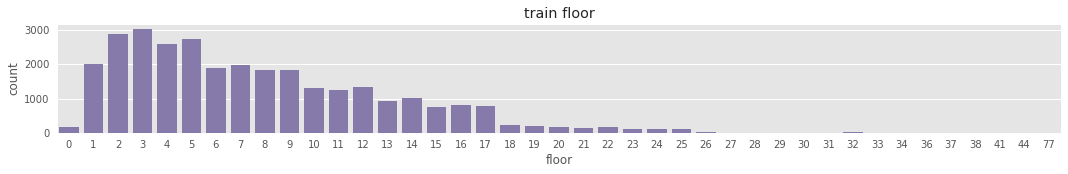

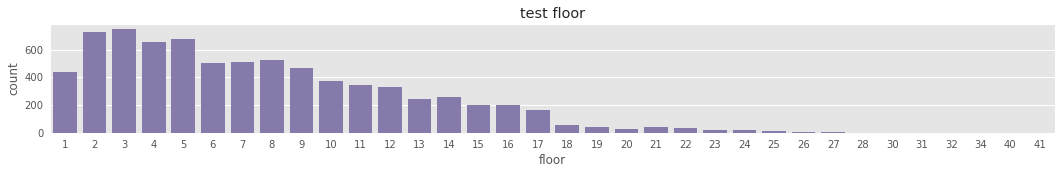

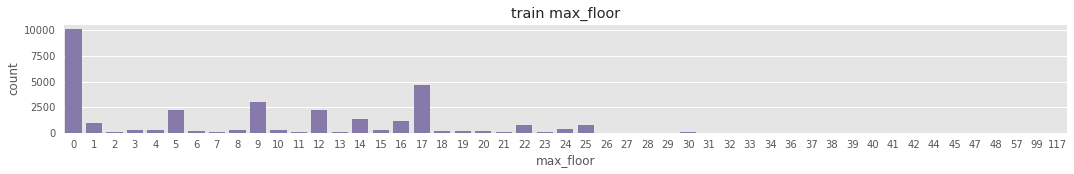

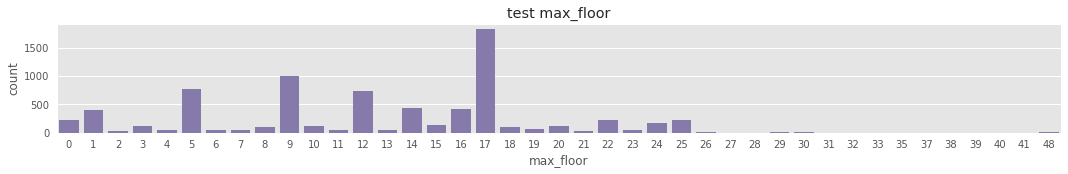

In [27]:
plt.figure(figsize=(18,2))
sns.countplot(train['floor'], color=color[3])
plt.title('train floor')
plt.figure(figsize=(18,2))
sns.countplot(test['floor'], color=color[3])
plt.title('test floor')
plt.figure(figsize=(18,2))
sns.countplot(train['max_floor'], color=color[3])
plt.title('train max_floor')
plt.figure(figsize=(18,2))
sns.countplot(test['max_floor'], color=color[3])
plt.title('test max_floor')
plt.show()

可以看出 floor 和 max_floor 的分布基本一致。

** material 字段 **

In [28]:
print train['material'].isnull().sum(), test['material'].isnull().sum()
set(test['material'])

9556 0


{1, 2, 3, 4, 5, 6}

In [29]:
perform_missing_data(train, ['material'], 0)
perform_missing_data(test, ['material'], 0)

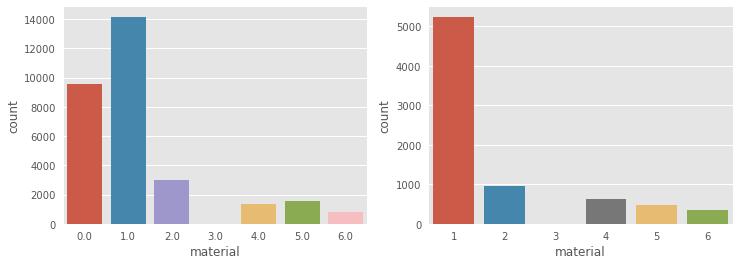

In [30]:
plt.figure(figsize=(12,4))
ax = plt.subplot(121)
sns.countplot(train['material'], ax=ax)
ax = plt.subplot(122)
sns.countplot(test['material'], ax=ax)
plt.show()

** build_year 字段 **

In [31]:
print train['build_year'].isnull().sum(), test['build_year'].isnull().sum()

13584 1049


In [32]:
perform_missing_data(train, ['build_year'], 0)
perform_missing_data(test, ['build_year'], 0)
train['build_year'] = train['build_year'].map(lambda x: int(x))
test['build_year'] = test['build_year'].map(lambda x: int(x))

In [33]:
train['build_year'][train['build_year'] > 0].min(), train['build_year'][train['build_year'] > 0].max()

(1, 20052009)

In [34]:
train['build_year'][train['build_year'] > test['build_year'][test['build_year'] > 0].max()]

10089    20052009
15220        4965
Name: build_year, dtype: int64

In [35]:
# 去除训练集中 build_year 异常的数据
train = train[train['build_year'] <= test['build_year'][test['build_year'] > 0].max()]
print train.shape

(30413, 296)


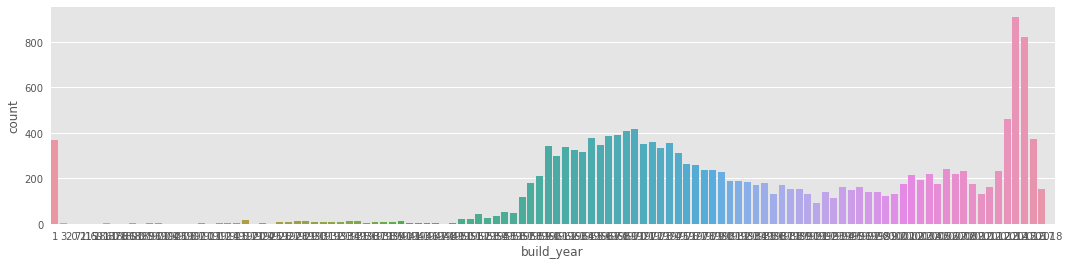

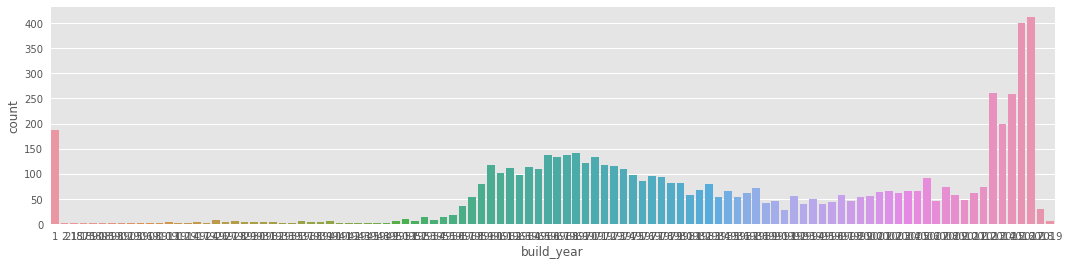

In [36]:
plt.figure(figsize=(18,4))
sns.countplot(train['build_year'][train['build_year'] > 0])
plt.figure(figsize=(18,4))
sns.countplot(test['build_year'][test['build_year'] > 0])
plt.show()

build_year 分布基本一致

** num_room 字段 ** number of living rooms

In [37]:
print train['num_room'].isnull().sum(), test['num_room'].isnull().sum()

9556 0


In [38]:
perform_missing_data(train, ['num_room'], -1)
perform_missing_data(test, ['num_room'], -1)
train['num_room'] = train['num_room'].map(lambda x: int(x))
test['num_room'] = test['num_room'].map(lambda x: int(x))

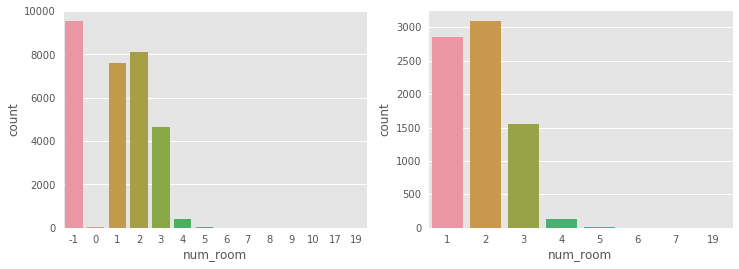

In [39]:
plt.figure(figsize=(12,4))
ax = plt.subplot(121)
sns.countplot(train['num_room'], ax=ax)
ax = plt.subplot(122)
sns.countplot(test['num_room'], ax=ax)
plt.show()

In [56]:
sum(train['num_room'] == 0)

14

In [63]:
train.loc[train['num_room'] == 0, 'num_room'] = -1
test.loc[test['num_room'] == 0, 'num_room'] = -1
train['per_living_room_sq'] = train['life_sq'] / train['num_room']
test['per_living_room_sq'] = test['life_sq'] / test['num_room']

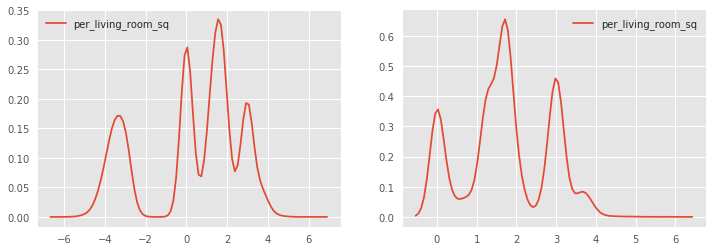

In [66]:
plt.figure(figsize=(12,4))
ax = plt.subplot(121)
sns.kdeplot(train['per_living_room_sq'], ax=ax)
ax = plt.subplot(122)
sns.kdeplot(test['per_living_room_sq'], ax=ax)
plt.show()

** state 字段**

In [68]:
print train['state'].isnull().sum(), test['state'].isnull().sum()

13540 694


In [75]:
perform_missing_data(train, ['state'], -1)
perform_missing_data(test, ['state'], -1)
train['state'] = train['state'].map(lambda x: int(x))
test['state'] = test['state'].map(lambda x: int(x))

In [76]:
set(train['state'])

{-1, 1, 2, 3, 4}

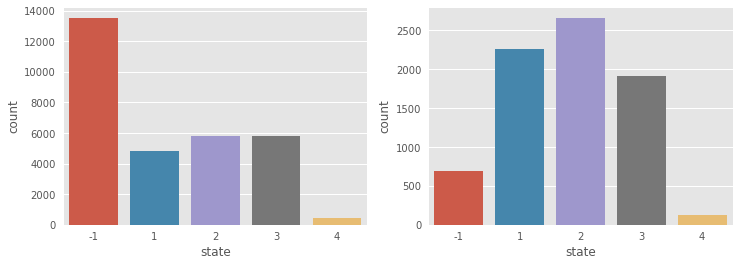

In [77]:
plt.figure(figsize=(12,4))
ax = plt.subplot(121)
sns.countplot(train['state'], ax=ax)
ax = plt.subplot(122)
sns.countplot(test['state'], ax=ax)
plt.show()

** product_type 字段**

In [78]:
print train['product_type'].isnull().sum(), test['product_type'].isnull().sum()

0 33


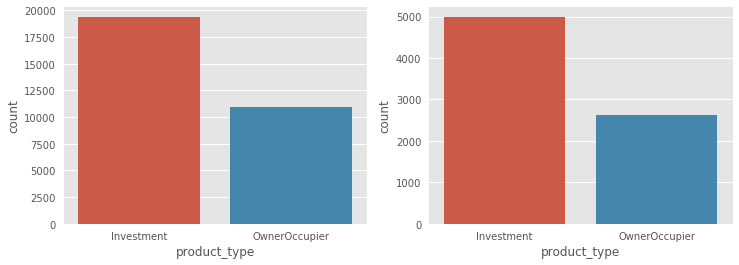

In [79]:
plt.figure(figsize=(12,4))
ax = plt.subplot(121)
sns.countplot(train['product_type'], ax=ax)
ax = plt.subplot(122)
sns.countplot(test['product_type'], ax=ax)
plt.show()

```
product_type
sub_area
area_m
raion_popul
green_zone_part
indust_part
children_preschool
preschool_quota
preschool_education_centers_raion
children_school
school_quota
school_education_centers_raion
school_education_centers_top_20_raion
hospital_beds_raion
healthcare_centers_raion
university_top_20_raion
sport_objects_raion
additional_education_raion
culture_objects_top_25
culture_objects_top_25_raion
shopping_centers_raion
office_raion
thermal_power_plant_raion
incineration_raion
oil_chemistry_raion
radiation_raion
railroad_terminal_raion
big_market_raion
nuclear_reactor_raion
detention_facility_raion
full_all
male_f
female_f
young_all
young_male
young_female
work_all
work_male
work_female
ekder_all
ekder_male
ekder_female
0_6_all
0_6_male
0_6_female
7_14_all
7_14_male
7_14_female
0_17_all
0_17_male
0_17_female
16_29_all
16_29_male
16_29_female
0_13_all
0_13_male
0_13_female
raion_build_count_with_material_info
build_count_block
build_count_wood
build_count_frame
build_count_brick
build_count_monolith
build_count_panel
build_count_foam
build_count_slag
build_count_mix
raion_build_count_with_builddate_info
build_count_before_1920
build_count_1921-1945
build_count_1946-1970
build_count_1971-1995
build_count_after_1995
ID_metro
metro_min_avto
metro_km_avto
metro_min_walk
metro_km_walk
kindergarten_km
school_km
park_km
green_zone_km
industrial_km
water_treatment_km
cemetery_km
incineration_km
railroad_station_walk_km
railroad_station_walk_min
ID_railroad_station_walk
railroad_station_avto_km
railroad_station_avto_min
ID_railroad_station_avto
public_transport_station_km
public_transport_station_min_walk
water_km
water_1line
mkad_km
ttk_km
sadovoe_km
bulvar_ring_km
kremlin_km
big_road1_km
ID_big_road1
big_road1_1line
big_road2_km
ID_big_road2
railroad_km
railroad_1line
zd_vokzaly_avto_km
ID_railroad_terminal
bus_terminal_avto_km
ID_bus_terminal
oil_chemistry_km
nuclear_reactor_km
radiation_km
power_transmission_line_km
thermal_power_plant_km
ts_km
big_market_km
market_shop_km
fitness_km
swim_pool_km
ice_rink_km
stadium_km
basketball_km
hospice_morgue_km
detention_facility_km
public_healthcare_km
university_km
workplaces_km
shopping_centers_km
office_km
additional_education_km
preschool_km
big_church_km
church_synagogue_km
mosque_km
theater_km
museum_km
exhibition_km
catering_km
ecology
green_part_500
prom_part_500
office_count_500
office_sqm_500
trc_count_500
trc_sqm_500
cafe_count_500
cafe_sum_500_min_price_avg
cafe_sum_500_max_price_avg
cafe_avg_price_500
cafe_count_500_na_price
cafe_count_500_price_500
cafe_count_500_price_1000
cafe_count_500_price_1500
cafe_count_500_price_2500
cafe_count_500_price_4000
cafe_count_500_price_high
big_church_count_500
church_count_500
mosque_count_500
leisure_count_500
sport_count_500
market_count_500
green_part_1000
prom_part_1000
office_count_1000
office_sqm_1000
trc_count_1000
trc_sqm_1000
cafe_count_1000
cafe_sum_1000_min_price_avg
cafe_sum_1000_max_price_avg
cafe_avg_price_1000
cafe_count_1000_na_price
cafe_count_1000_price_500
cafe_count_1000_price_1000
cafe_count_1000_price_1500
cafe_count_1000_price_2500
cafe_count_1000_price_4000
cafe_count_1000_price_high
big_church_count_1000
church_count_1000
mosque_count_1000
leisure_count_1000
sport_count_1000
market_count_1000
green_part_1500
prom_part_1500
office_count_1500
office_sqm_1500
trc_count_1500
trc_sqm_1500
cafe_count_1500
cafe_sum_1500_min_price_avg
cafe_sum_1500_max_price_avg
cafe_avg_price_1500
cafe_count_1500_na_price
cafe_count_1500_price_500
cafe_count_1500_price_1000
cafe_count_1500_price_1500
cafe_count_1500_price_2500
cafe_count_1500_price_4000
cafe_count_1500_price_high
big_church_count_1500
church_count_1500
mosque_count_1500
leisure_count_1500
sport_count_1500
market_count_1500
green_part_2000
prom_part_2000
office_count_2000
office_sqm_2000
trc_count_2000
trc_sqm_2000
cafe_count_2000
cafe_sum_2000_min_price_avg
cafe_sum_2000_max_price_avg
cafe_avg_price_2000
cafe_count_2000_na_price
cafe_count_2000_price_500
cafe_count_2000_price_1000
cafe_count_2000_price_1500
cafe_count_2000_price_2500
cafe_count_2000_price_4000
cafe_count_2000_price_high
big_church_count_2000
church_count_2000
mosque_count_2000
leisure_count_2000
sport_count_2000
market_count_2000
green_part_3000
prom_part_3000
office_count_3000
office_sqm_3000
trc_count_3000
trc_sqm_3000
cafe_count_3000
cafe_sum_3000_min_price_avg
cafe_sum_3000_max_price_avg
cafe_avg_price_3000
cafe_count_3000_na_price
cafe_count_3000_price_500
cafe_count_3000_price_1000
cafe_count_3000_price_1500
cafe_count_3000_price_2500
cafe_count_3000_price_4000
cafe_count_3000_price_high
big_church_count_3000
church_count_3000
mosque_count_3000
leisure_count_3000
sport_count_3000
market_count_3000
green_part_5000
prom_part_5000
office_count_5000
office_sqm_5000
trc_count_5000
trc_sqm_5000
cafe_count_5000
cafe_sum_5000_min_price_avg
cafe_sum_5000_max_price_avg
cafe_avg_price_5000
cafe_count_5000_na_price
cafe_count_5000_price_500
cafe_count_5000_price_1000
cafe_count_5000_price_1500
cafe_count_5000_price_2500
cafe_count_5000_price_4000
cafe_count_5000_price_high
big_church_count_5000
church_count_5000
mosque_count_5000
leisure_count_5000
sport_count_5000
market_count_5000
price_doc
yearmonth
life_sq_ratio
kitch_sq_ratio
kitch_sq_vs_life_ratio


```